In [1]:
import numpy as np
import mesa_reader as mr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.ticker as ticker
import pandas as pd
import scipy

import scienceplots
plt.style.use('science')

plt.rcParams.update({'font.size': 11})

In [14]:
h1 = mr.MesaData("low_mass_exercise2/LOGS/history.data")
h2 = mr.MesaData("low_mass/LOGS/history.data")

FileNotFoundError: low_mass_exercise2/LOGS/history.data not found.

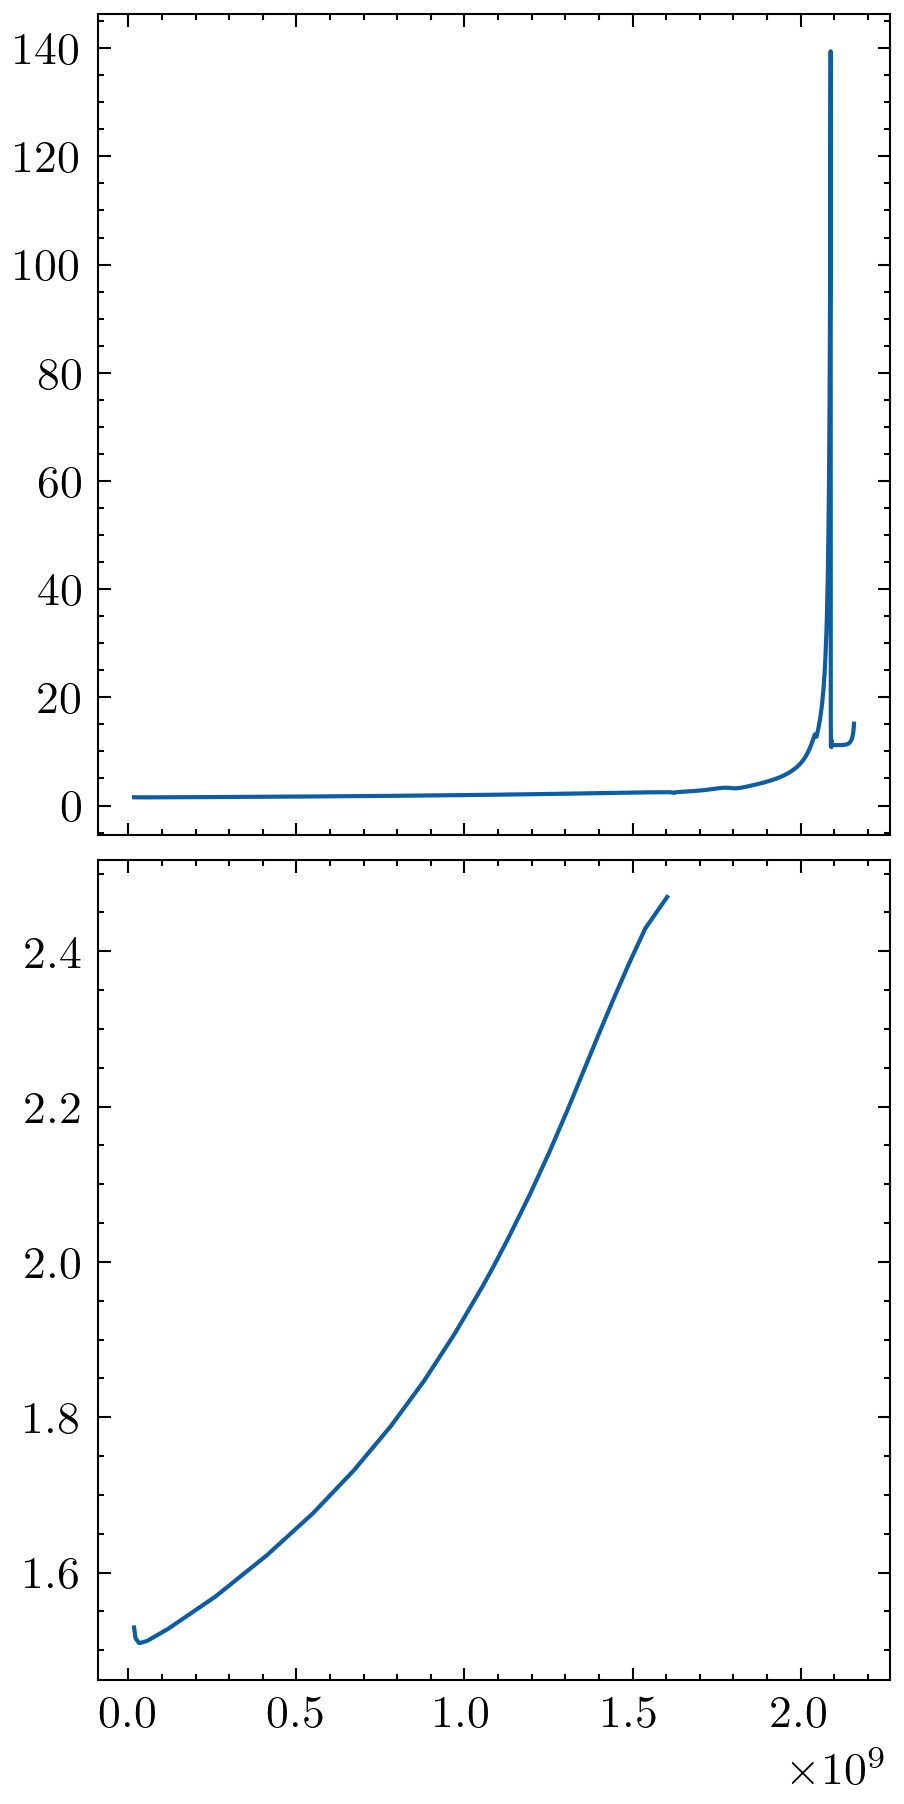

In [ ]:
mask1 = h1.log_Lnuc / h1.log_L > 0.99 
mask2 = h2.log_Lnuc / h2.log_L > 0.99

radius1 = 10**h1.log_R[mask1]
radius2 = 10**h2.log_R[mask2]

star_age1 = h1.star_age[mask1]
star_age2 = h2.star_age[mask2]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 6), sharex=True, dpi=300, layout="constrained")

ax1.plot(star_age1, radius1)
ax2.plot(star_age2, radius2)


### Q.4.3

In [2]:
l = mr.MesaLogDir("low_mass_with_h2/LOGS")

In [3]:
model_nums

NameError: name 'model_nums' is not defined

In [144]:
# Define predicate function
def hot_core(logT, star_age):
    return logT > 6  # logT in Kelvin, star_age in seconds

model_nums = l.select_models(hot_core, 'log_center_T', 'star_age')


# Collect data from all profiles
ages = []
masses = []
X_H2 = []


for prof in model_nums:
    data = l.profile_data(model_number=prof)
    age = l.profile_data(model_number=prof).header('star_age')
    n = len(data.mass)
    ages.append(np.full(n, age))
    masses.append(data.mass)
    X_H2.append(data.h2)

ages = np.concatenate(ages) / 1e6  # Convert ages to Gyr
masses = np.concatenate(masses)
X_H2 = np.concatenate(X_H2)

def plot_mass_fraction_map(ages, masses, fraction, label, cmap):
    plt.figure(figsize=(3, 3), dpi=300)
    sc = plt.scatter(ages, masses, c=fraction, cmap=cmap, s=10, rasterized=True)
    plt.xlabel("Star Age [Myr]")
    plt.ylabel("Mass Coordinate [M$_\odot$]")
    plt.ylim(masses.min(), masses.max())
    plt.colorbar(sc, label=label)
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"../plots/q42_abundancy_{label[-3]}.pdf", dpi=300, bbox_inches='tight')

# Filter for inner mass coordinate regions, e.g., mass < 0.1
inner_mask = masses < 2


In [44]:
from matplotlib.ticker import LogFormatterSciNotation
def plot_mass_fraction_map(ages, masses, fraction, label, cmap, vmin=None, vmax=None):
    plt.figure(figsize=(3, 3), dpi=300)
    norm = LogNorm(vmin=vmin, vmax=vmax) if vmin is not None and vmax is not None else LogNorm()
    sc = plt.scatter(np.log10(ages), masses, c=fraction, cmap=cmap, s=2, marker="s", rasterized=True, norm=norm)
    plt.xlabel("$\log$(Age /Myr)")
    plt.ylabel("Mass Coordinate [M$_\odot$]")
    plt.xlim(np.log10(ages.min()), np.log10(ages.max()))
    plt.ylim(masses.min(), masses.max())
    plt.colorbar(sc)  # No label argument, so no legend

    ax = plt.gca()
    major_locator = ticker.MultipleLocator(1)
    minor_locator = ticker.AutoMinorLocator(5)
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

    plt.tight_layout()
    plt.show()


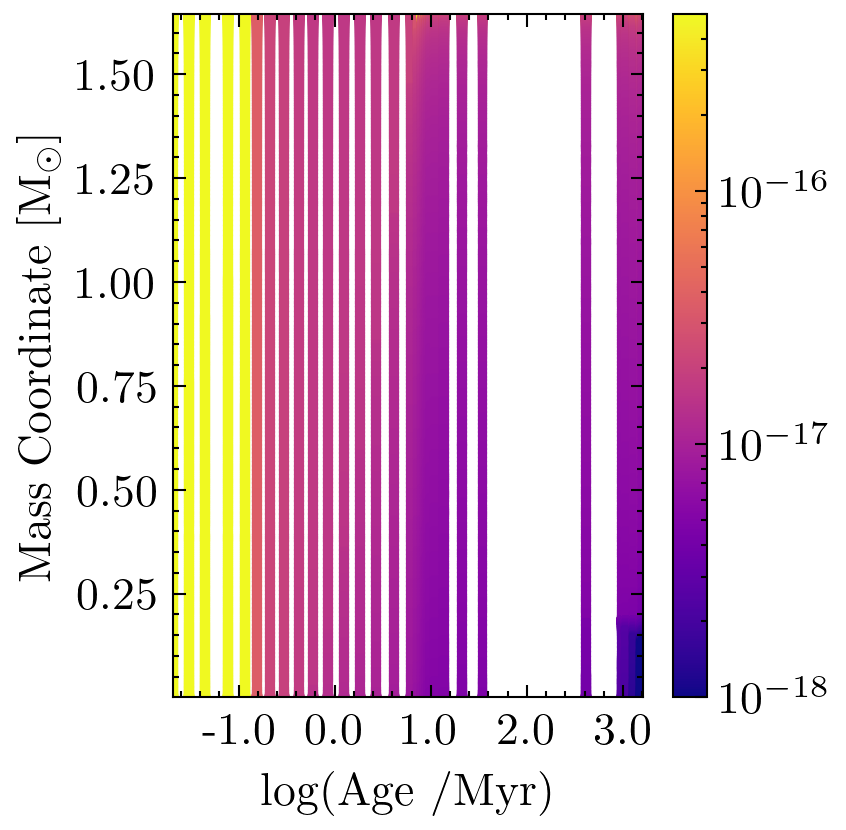

In [60]:
plot_mass_fraction_map(
    ages[inner_mask],
    masses[inner_mask],
    X_H2[inner_mask],
    r"$X_\text{H2}$",
    "plasma", vmin=1e-18, vmax=5e-16
)

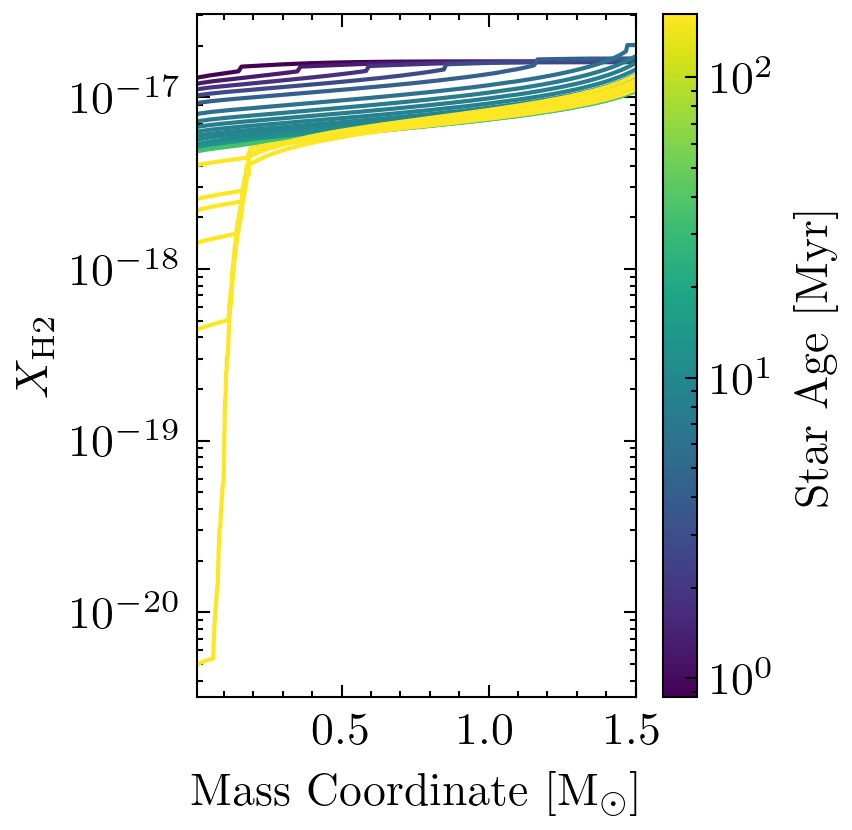

In [147]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
# Collect ages for color mapping
ages_for_color = []
profiles = []
for prof in model_nums[10::1]:
    data = l.profile_data(model_number=prof)
    profiles.append(data)
    ages_for_color.append(data.header('star_age') / 1e6)  # Convert to Myr

ages_for_color = np.array(ages_for_color)

norm = LogNorm(vmin=ages_for_color.min(), vmax=ages_for_color.max() / 10)
cmap = plt.get_cmap('viridis')

for data, age in zip(profiles, ages_for_color):
    inner_mask = data.mass < 1.5
    ax.plot(data.mass[inner_mask], data.h2[inner_mask], color=cmap(norm(age)))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label="Star Age [Myr]")

ax.set_xlim(0.01, 1.5)
ax.set_xlabel("Mass Coordinate [M$_\odot$]")
ax.set_ylabel(r"$X_\mathrm{H2}$")
ax.set_yscale('log')
plt.tight_layout()
plt.show()


C:\Users\bruno\AppData\Local\Temp\ipykernel_16144\2576625175.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(3, 3), dpi=300, tight_layout=True)


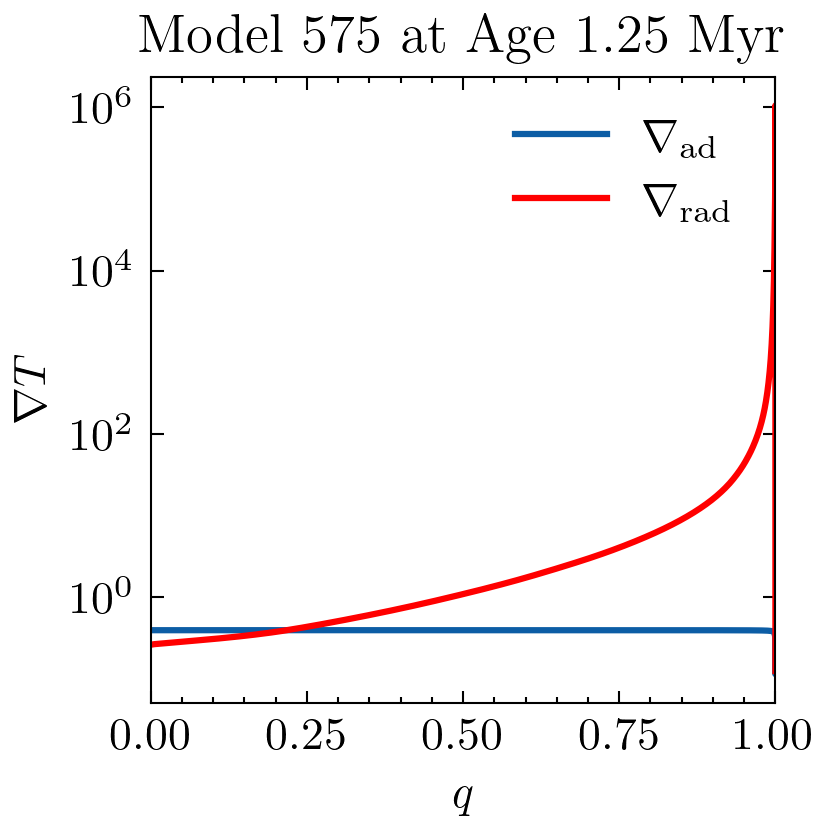

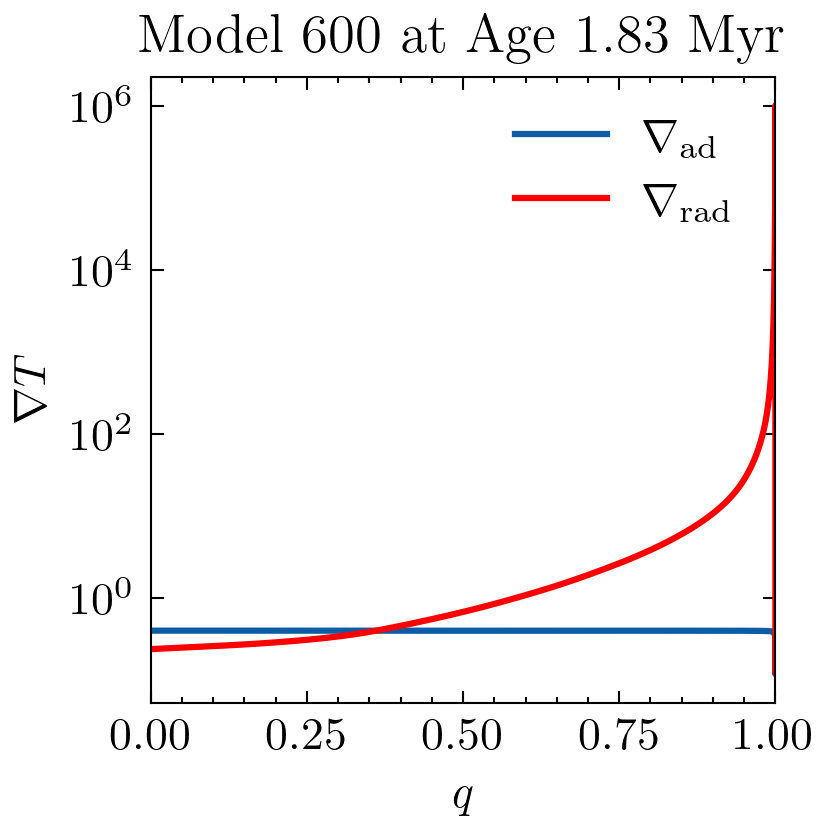

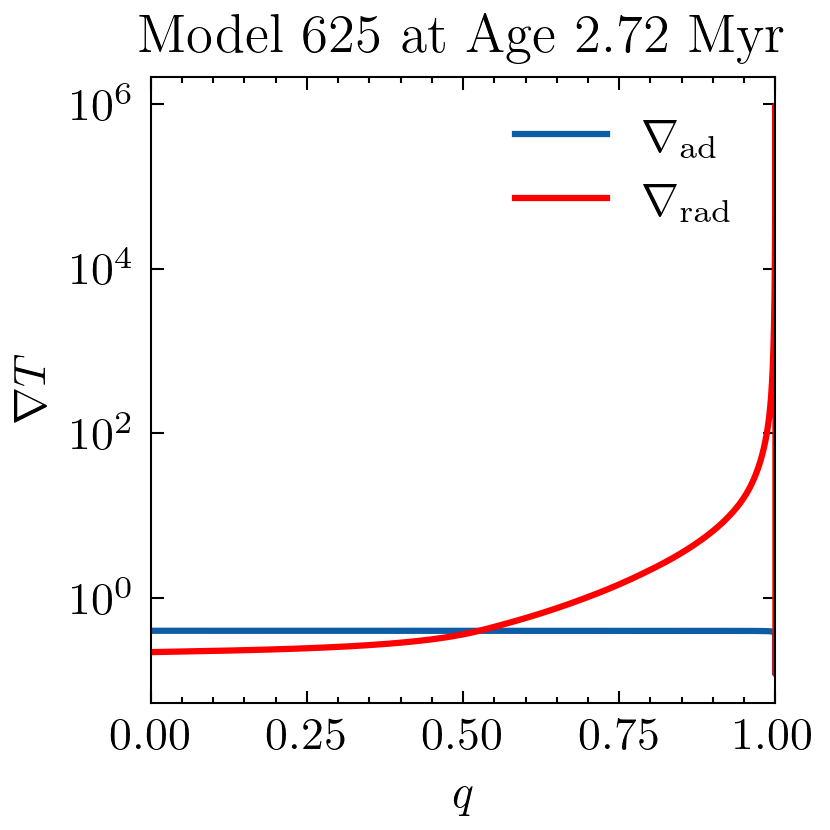

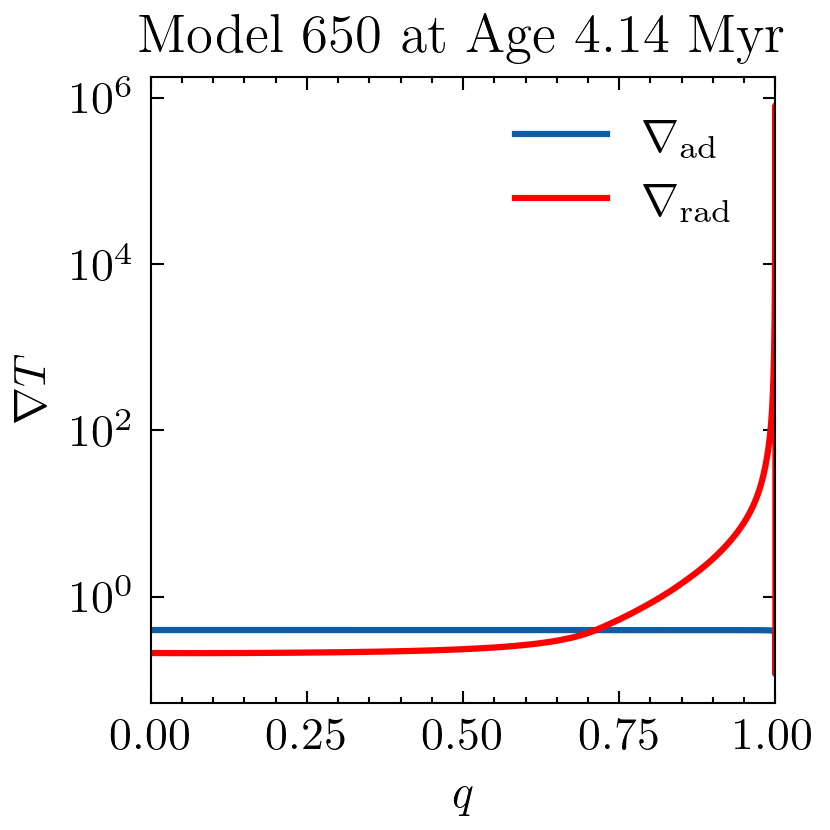

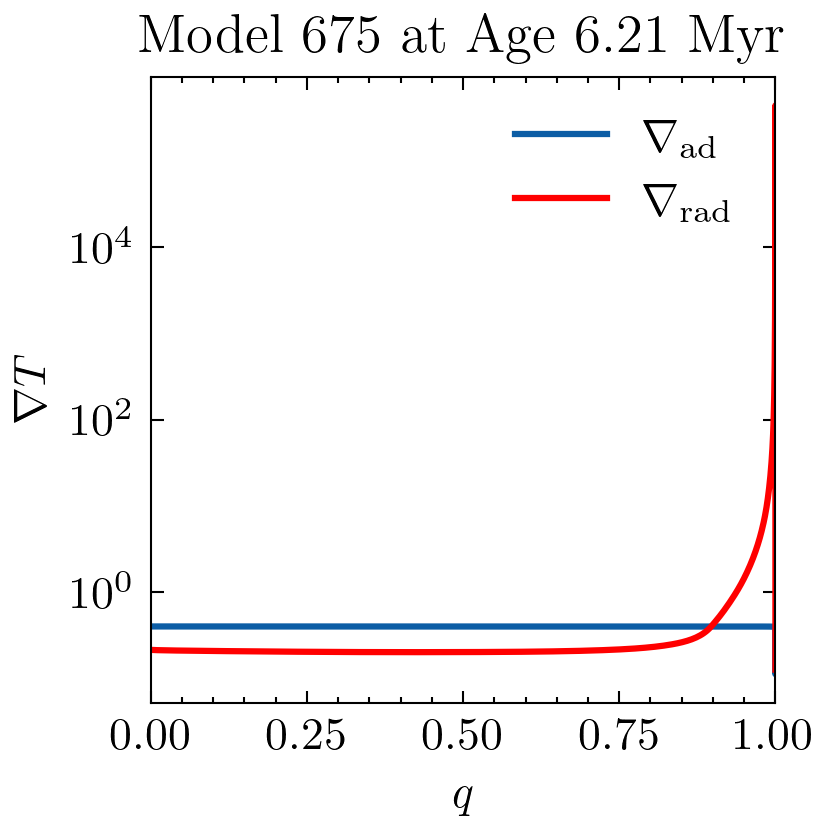

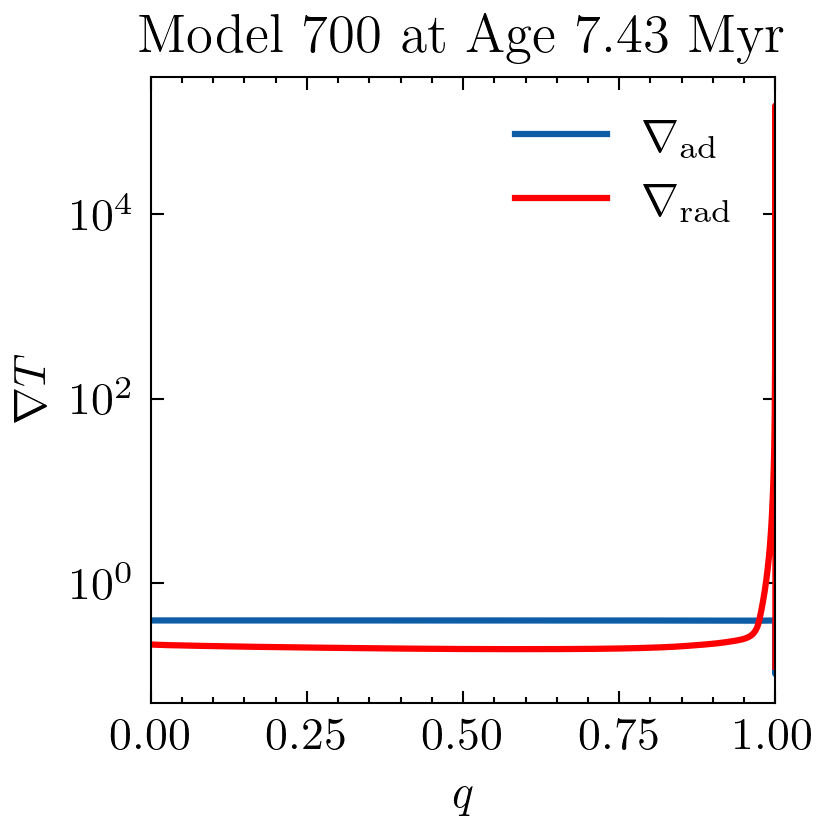

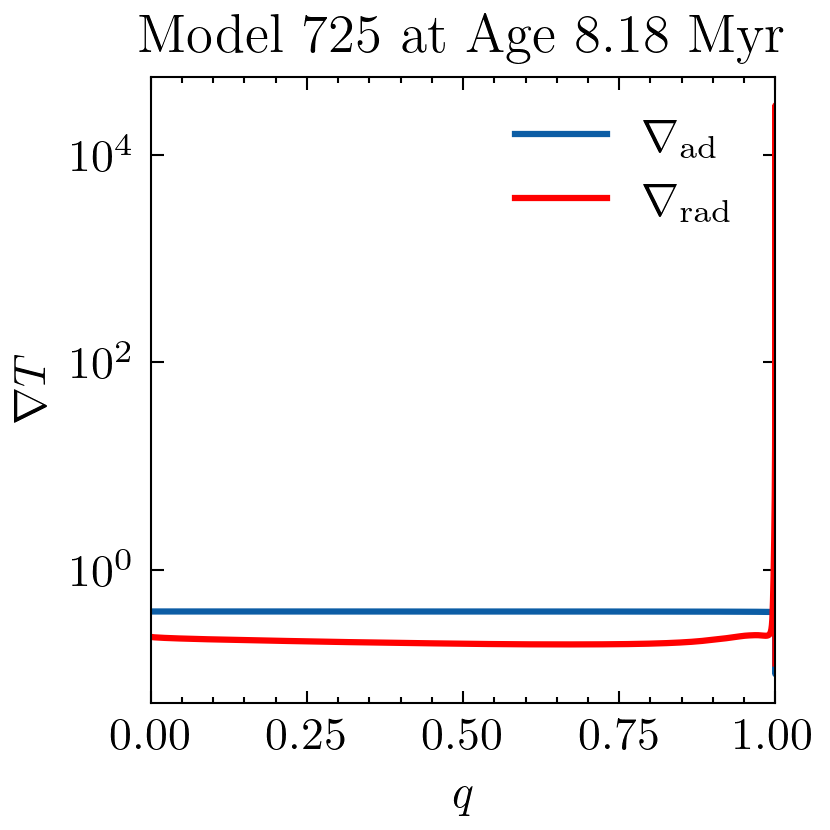

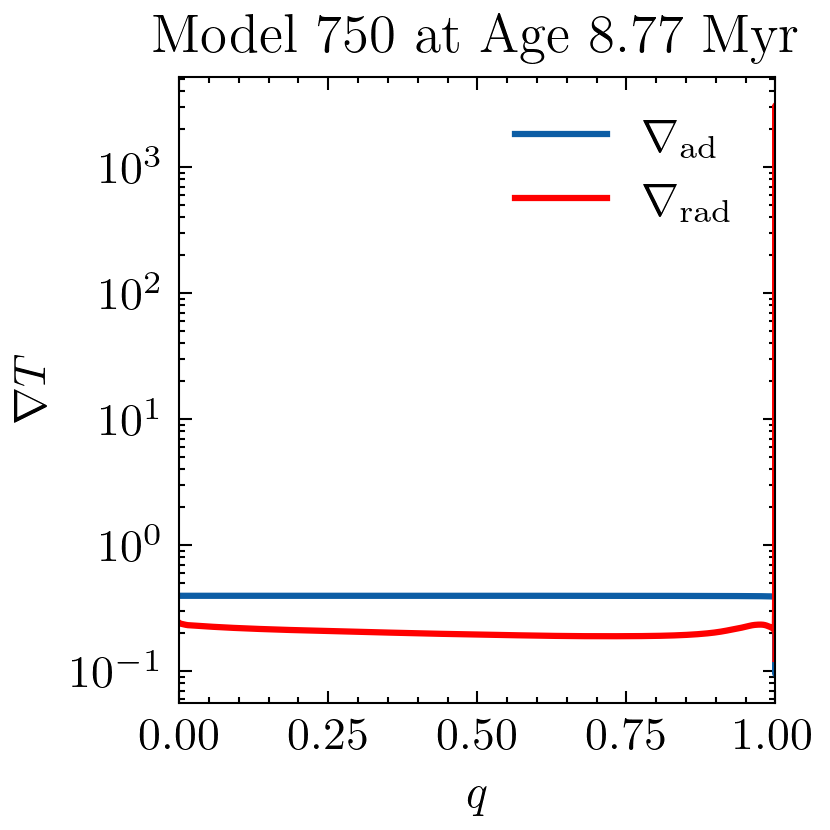

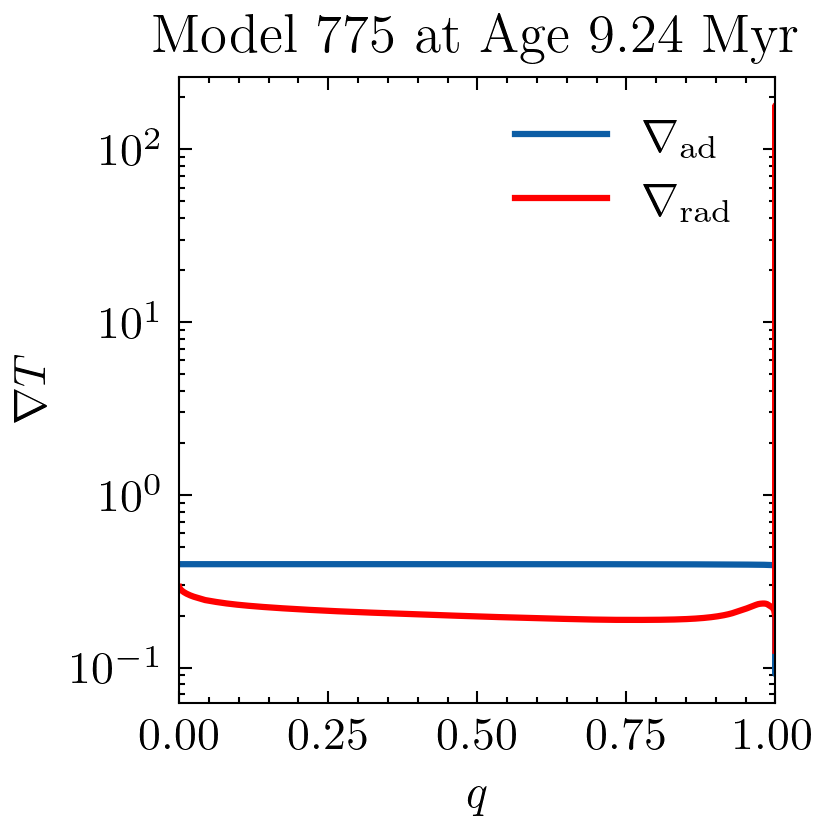

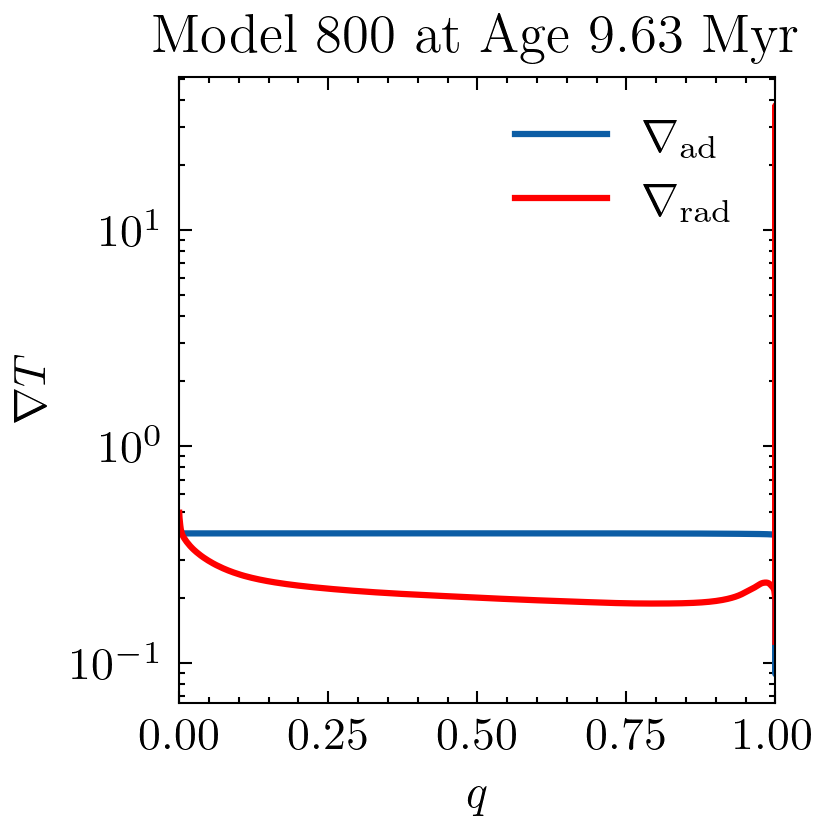

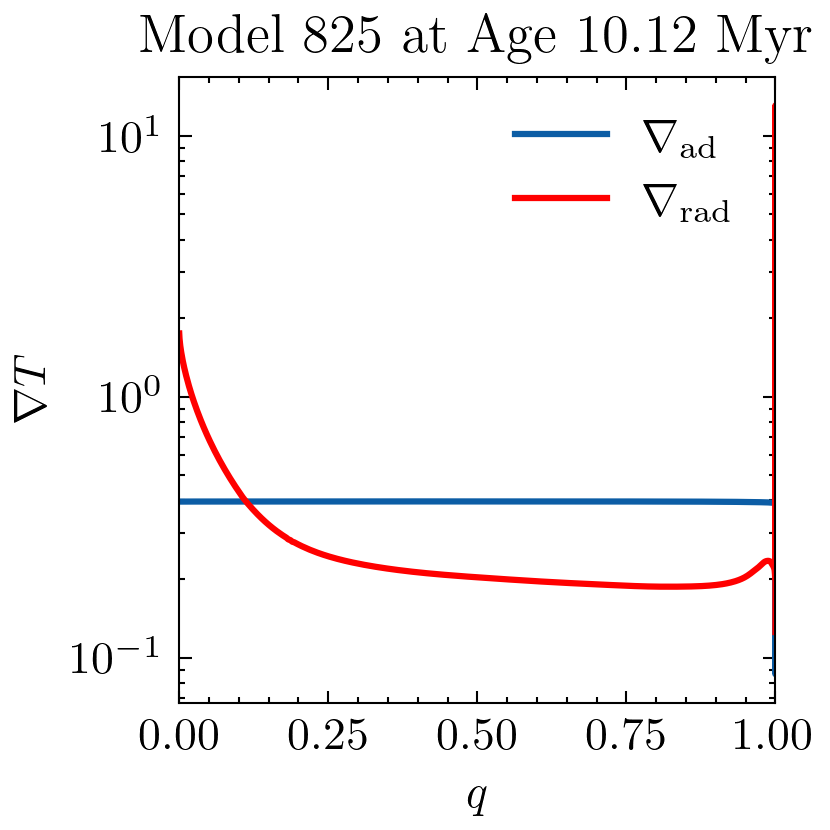

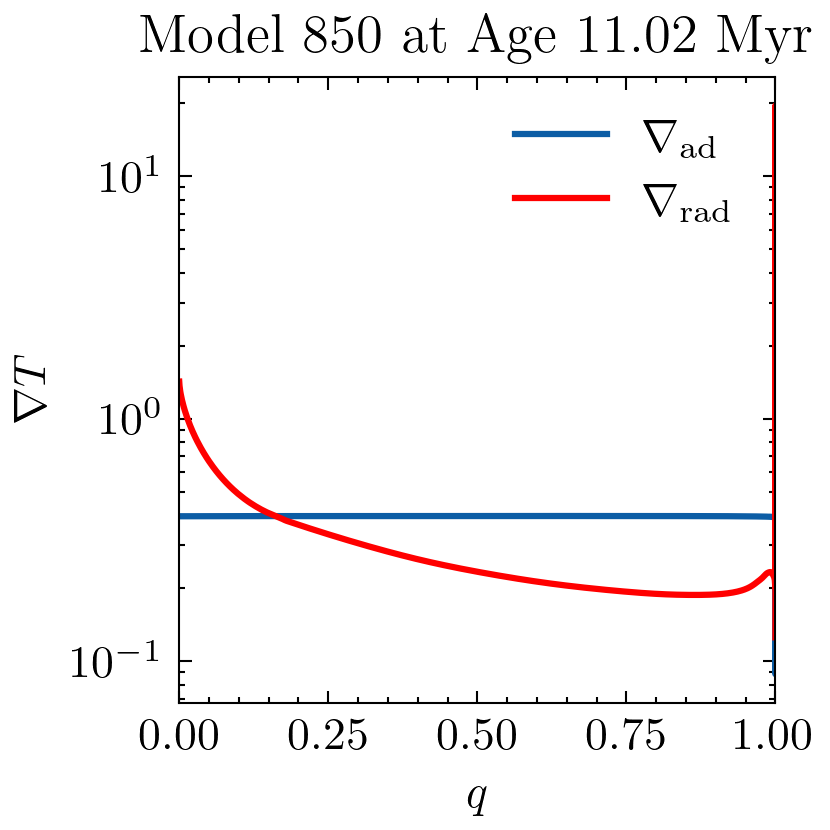

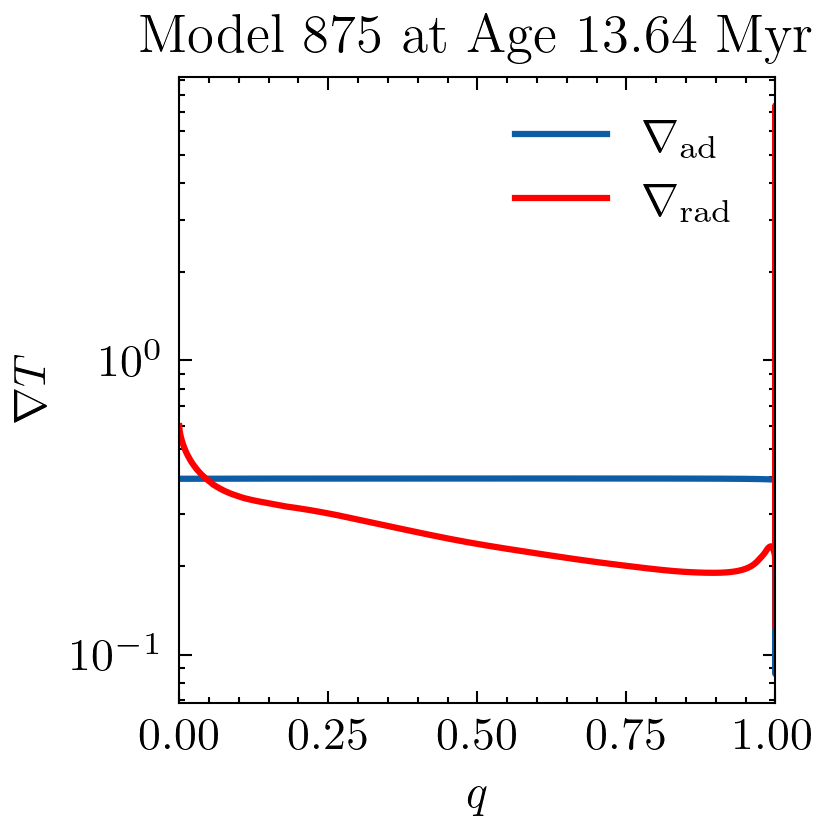

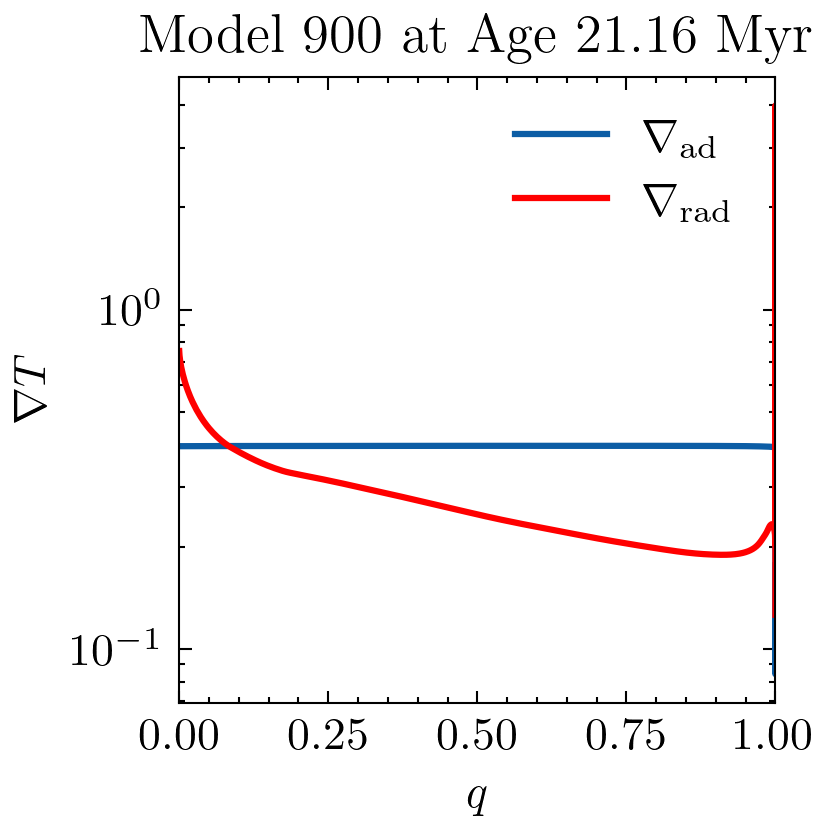

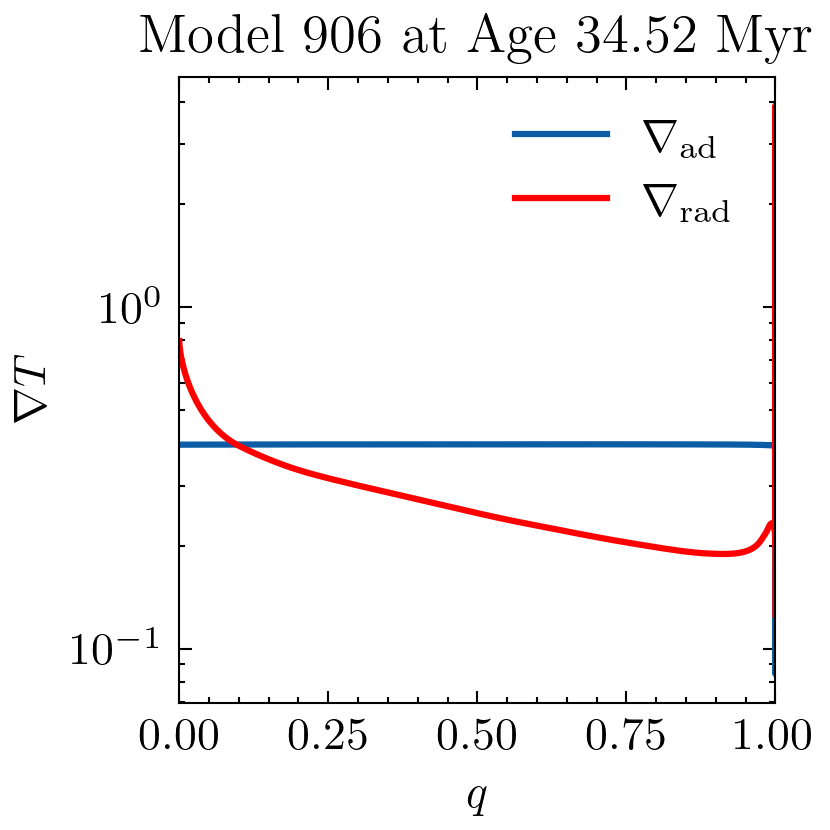

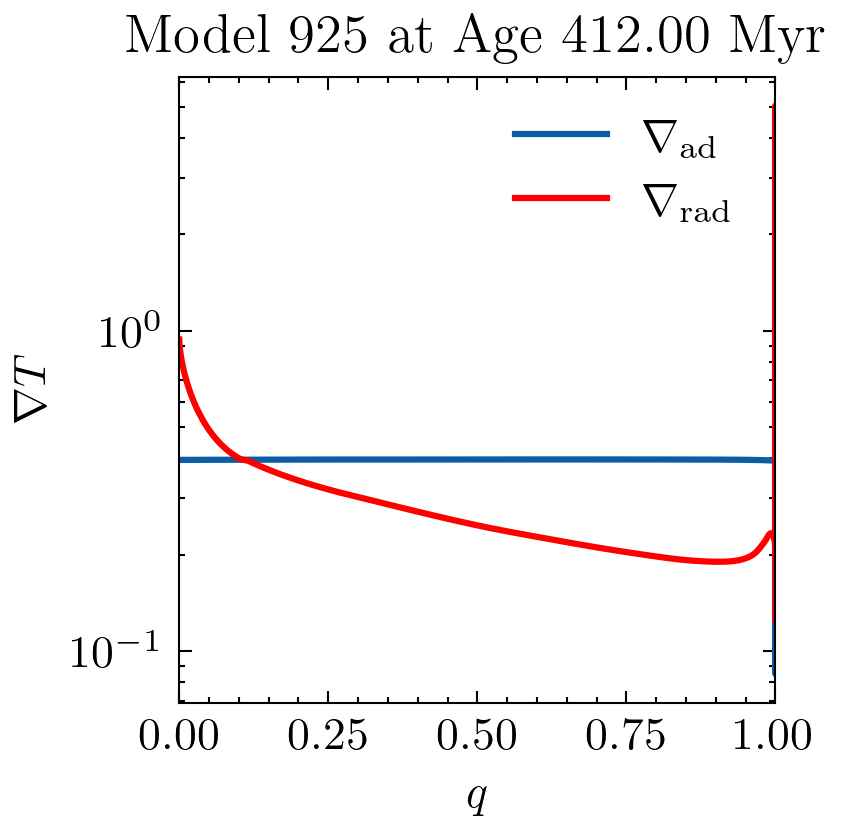

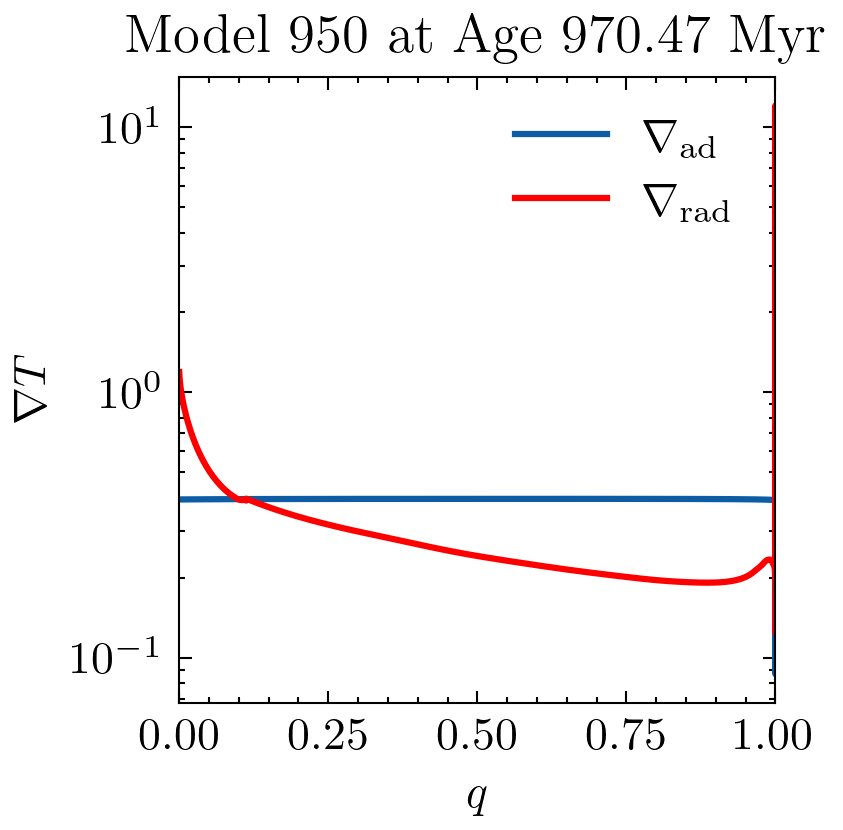

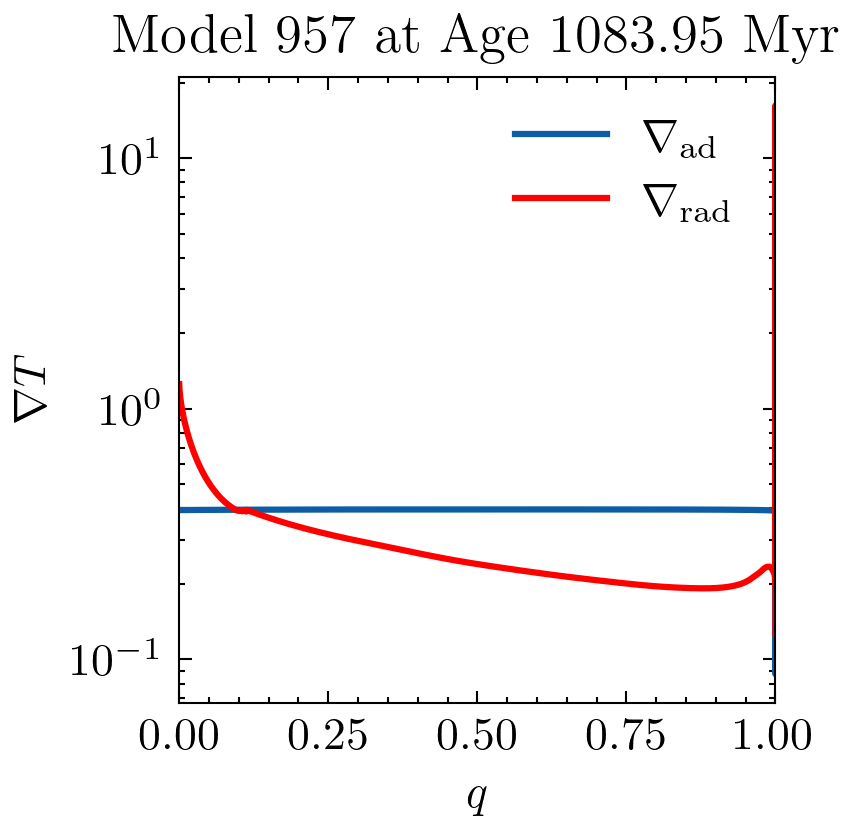

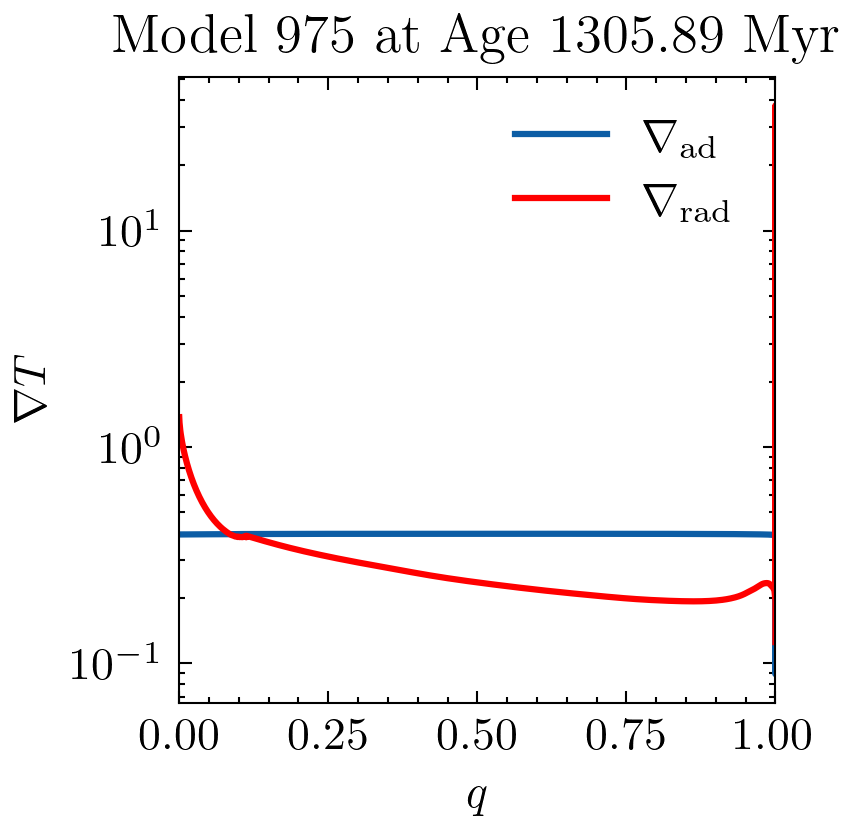

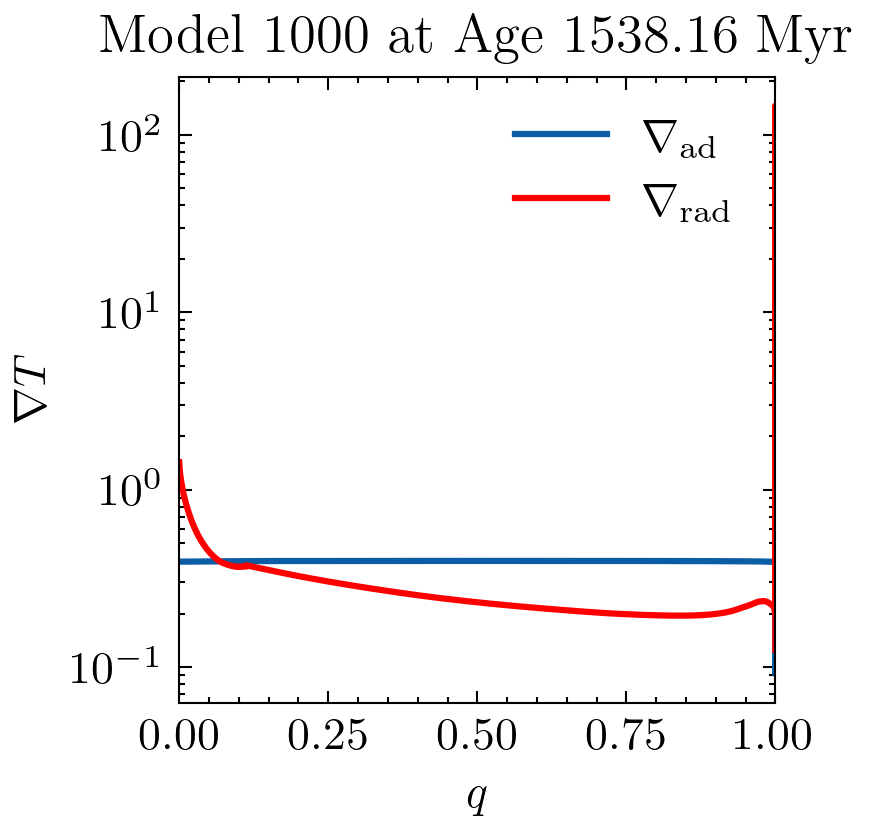

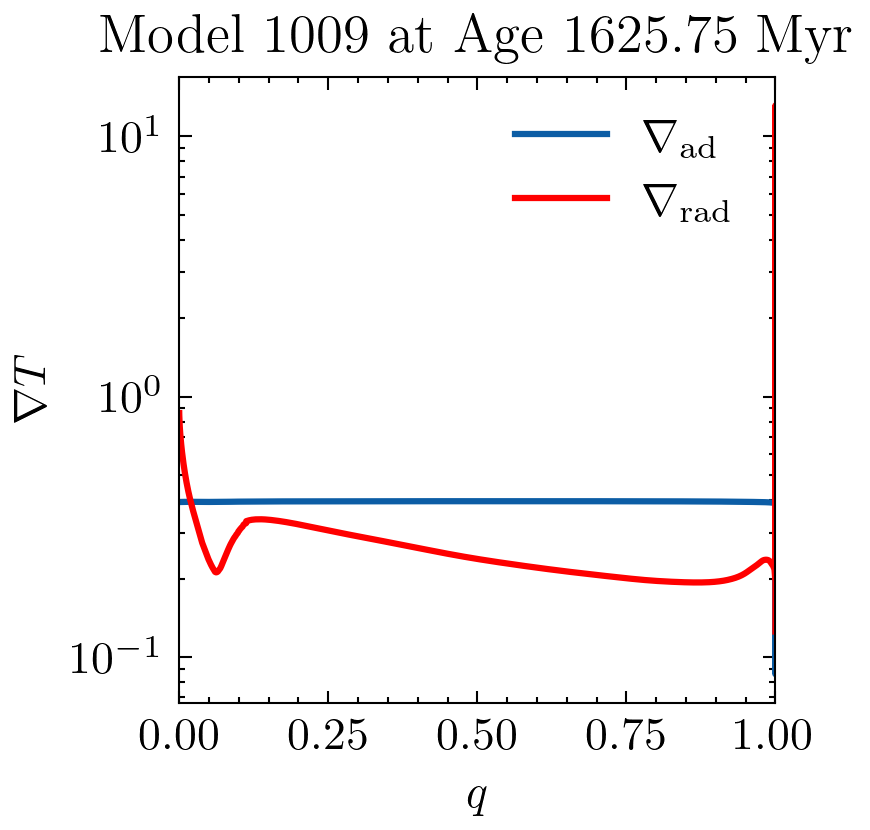

In [140]:
# Define predicate function
def hot_core(logT, star_age):
    return logT > 6 and star_age > 1e6 # logT in Kelvin, star_age in seconds

model_nums = l.select_models(hot_core, 'log_center_T', 'star_age')


for model_num in model_nums:
    data = l.profile_data(model_number=model_num)

    fig, ax = plt.subplots(figsize=(3, 3), dpi=300, tight_layout=True)

    ax.plot(data.q, data.grada, color='C0', lw=1.5, label=r'$\nabla_{\text{ad}}$')
    ax.plot(data.q, data.gradr, color='r', lw=1.5, label=r'$\nabla_{\text{rad}}$')

    ax.set_xlim(0, 1)

    ax.set_xlabel(r'$q$')
    ax.set_ylabel(r'$\nabla T$')
    ax.legend(loc='upper right', frameon=False, fontsize=11)
    ax.set_yscale('log')

    ax.set_title(f"Model {model_num} at Age {data.header('star_age') / 1e6:.2f} Myr")

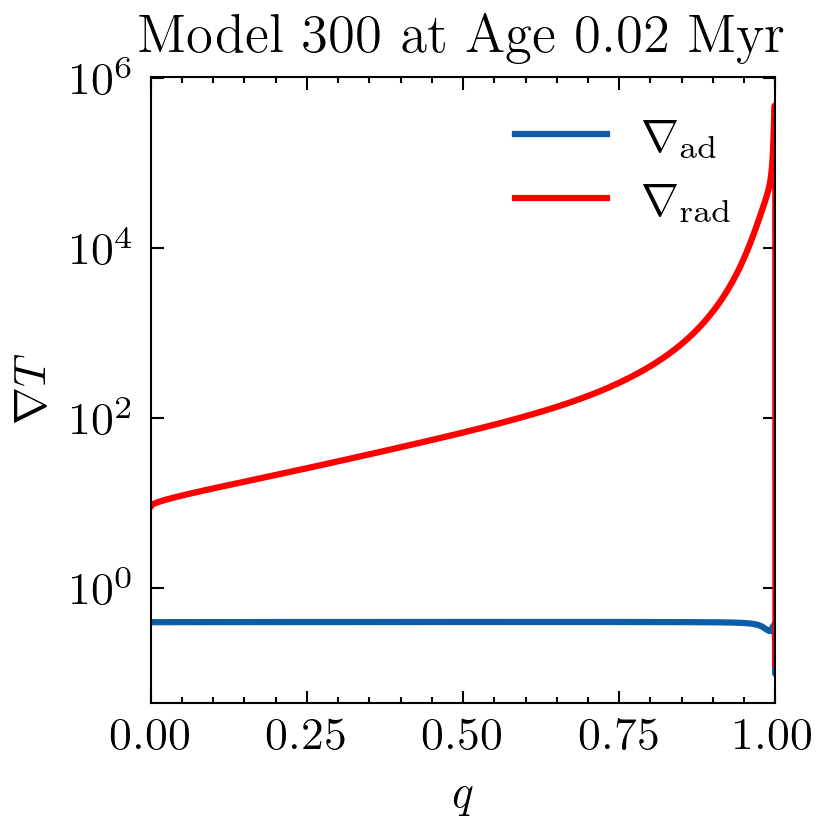

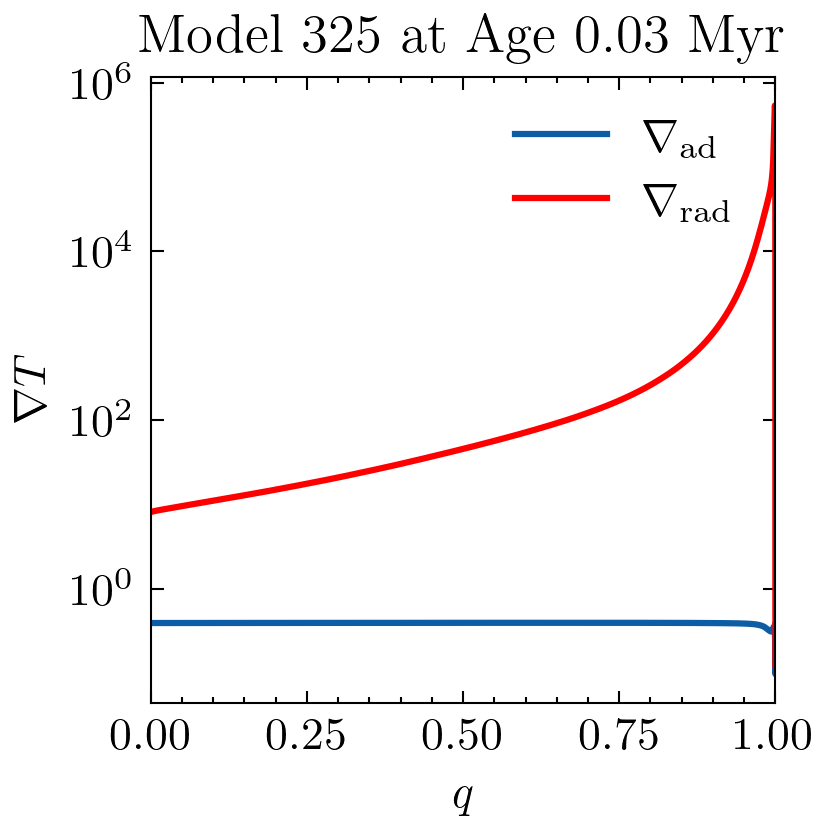

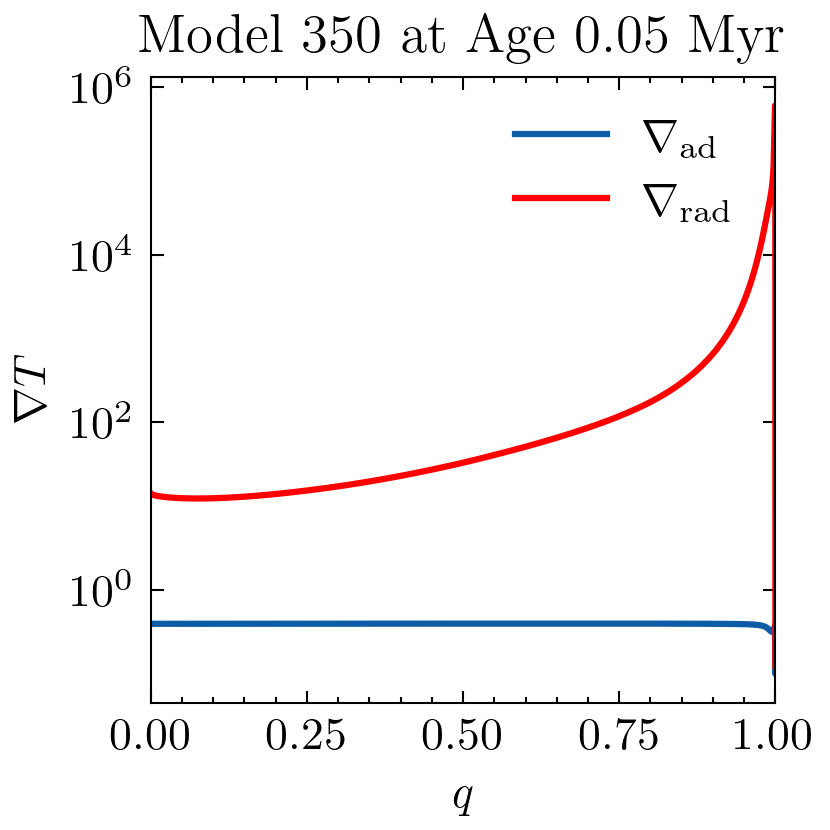

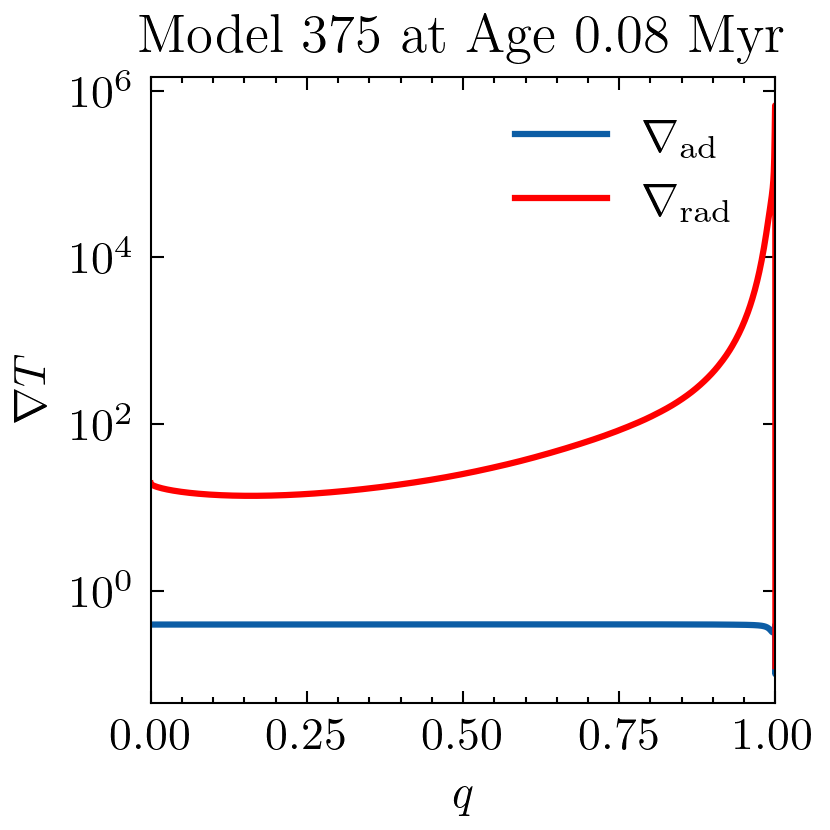

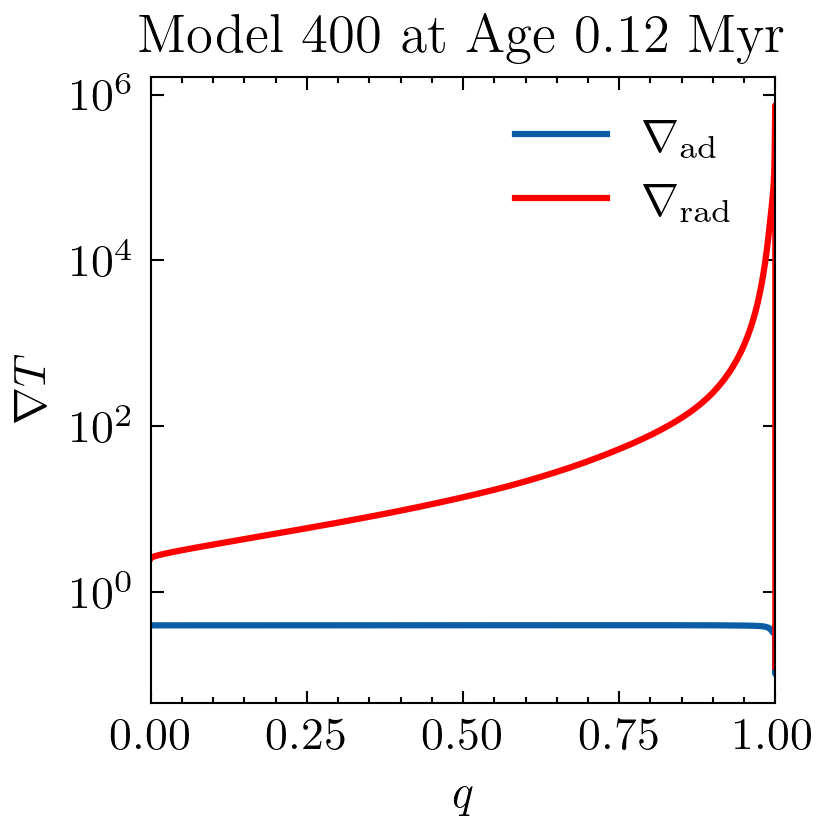

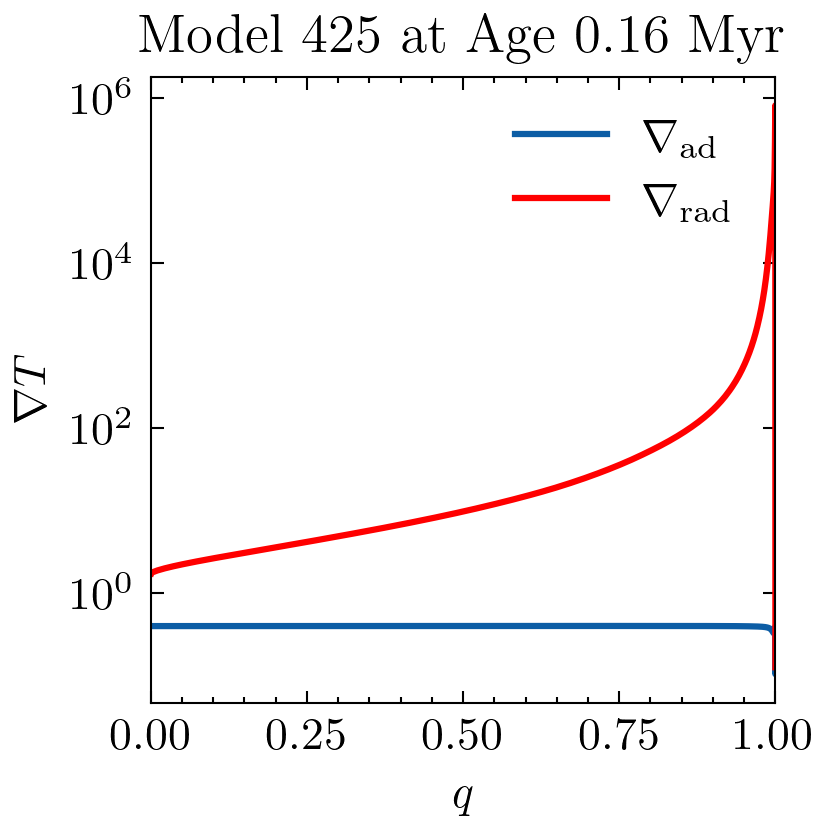

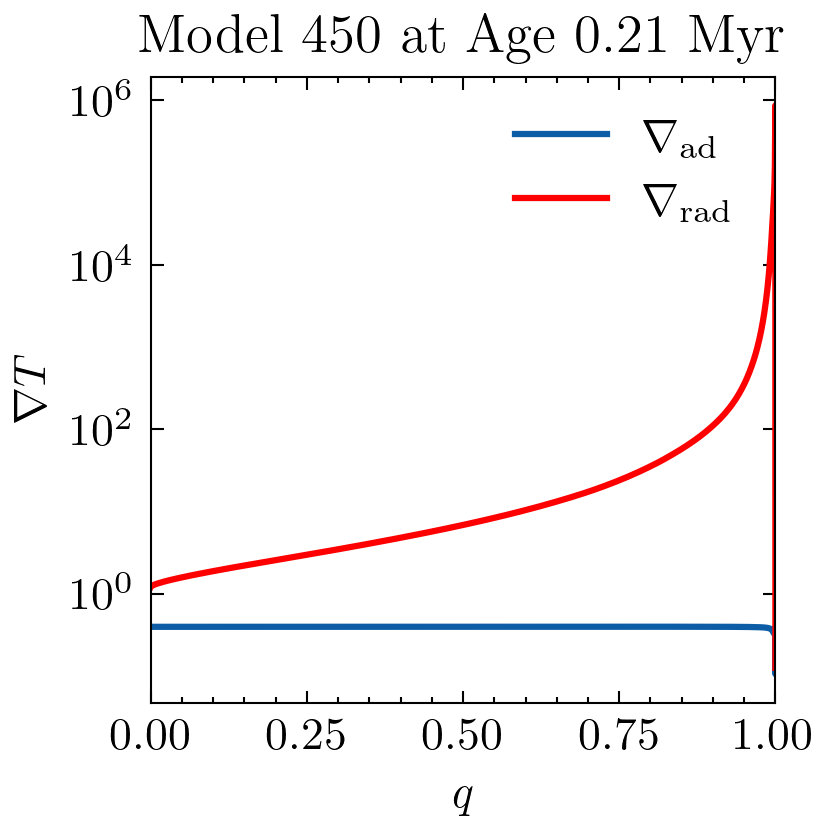

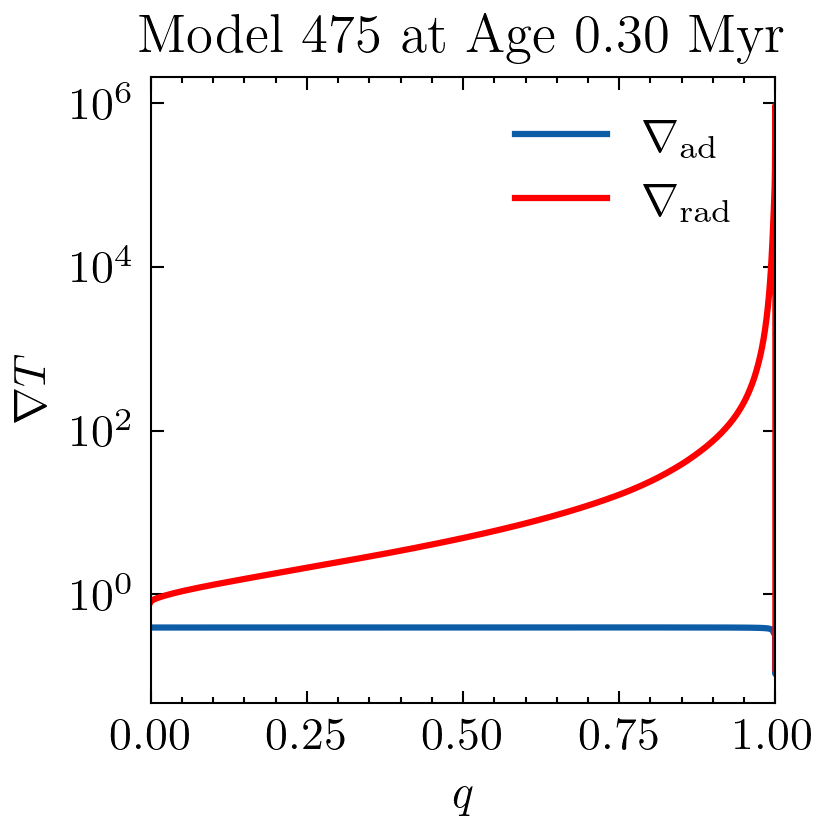

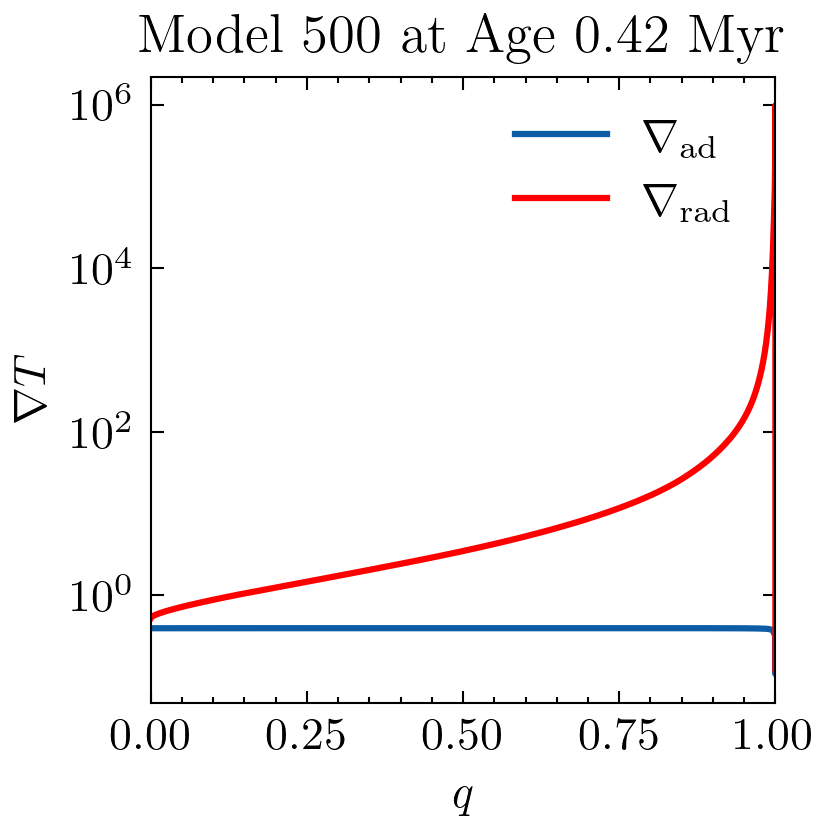

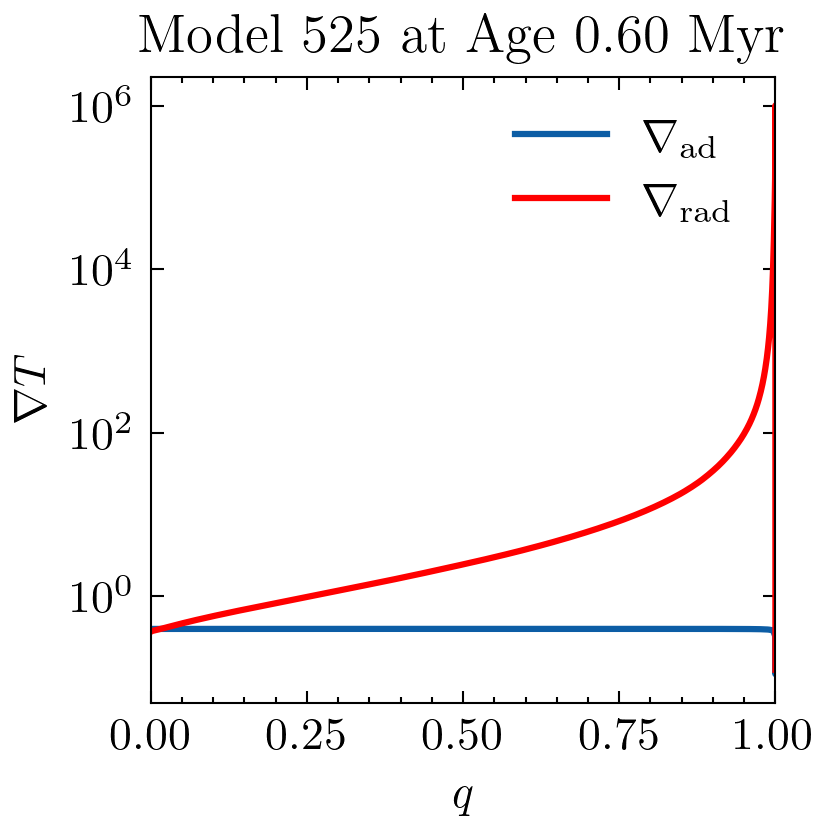

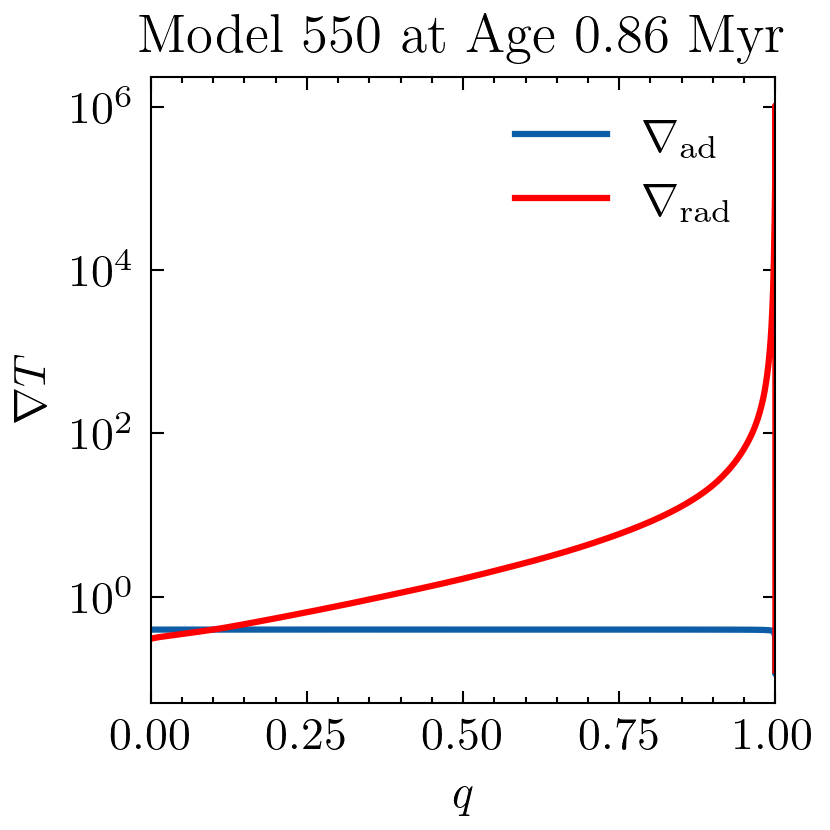

In [139]:
# Define predicate function
def hot_core(logT, star_age):
    return logT > 6 and star_age < 1e6 # logT in Kelvin, star_age in seconds

model_nums = l.select_models(hot_core, 'log_center_T', 'star_age')


for model_num in model_nums:
    data = l.profile_data(model_number=model_num)

    fig, ax = plt.subplots(figsize=(3, 3), dpi=300, tight_layout=True)

    ax.plot(data.q, data.grada, color='C0', lw=1.5, label=r'$\nabla_{\text{ad}}$')
    ax.plot(data.q, data.gradr, color='r', lw=1.5, label=r'$\nabla_{\text{rad}}$')

    ax.set_xlim(0, 1)

    ax.set_xlabel(r'$q$')
    ax.set_ylabel(r'$\nabla T$')
    ax.legend(loc='upper right', frameon=False, fontsize=11)
    ax.set_yscale('log')

    ax.set_title(f"Model {model_num} at Age {data.header('star_age') / 1e6:.2f} Myr")